In [11]:
import os
os.getcwd()

'C:\\Users\\alex-\\Documents\\Git Hub'

In [96]:
import urllib.request          as     url
import pandas                  as     pd
from   sklearn                 import tree
import graphviz                as     gv
import numpy                   as     np
from   sklearn.metrics         import accuracy_score
from   sklearn.model_selection import train_test_split
from   sklearn.ensemble        import BaggingClassifier,RandomForestClassifier
import matplotlib.pylab        as     plt 
import sklearn
from   sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from   sklearn.ensemble        import AdaBoostClassifier,GradientBoostingClassifier
from sklearn import metrics

In [17]:
data=pd.read_csv('sonar.csv',sep=',',header=0)
data.shape
data.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V52,V53,V54,V55,V56,V57,V58,V59,V60,Y
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.018,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.014,0.0049,0.0052,0.0044,R


Tenemos 111 registros de minas y 97 casos de rocas

In [18]:
print(pd.value_counts(data['Y']))

M    111
R     97
Name: Y, dtype: int64


Tomamos los datos de entrenamiento

In [19]:
y=data.pop("Y")
X=data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

no. de observaciones entre minas y rocas en la base de entrenamiento

In [20]:
print(pd.value_counts(y_train))

M    76
R    69
Name: Y, dtype: int64


Ajustando el modelo usando el índice de Gini como medida de impureza

In [21]:
seed=7
tr=tree.DecisionTreeClassifier(criterion="gini",max_depth=7,max_leaf_nodes=7)
trf=tr.fit(X_train,y_train)

Vamos a ver el porcentaje de datos bien clasificados y el número

In [25]:
yp=trf.predict(X_test)
print('Porcentaje de datos bien clasificados')
print(accuracy_score(y_test,yp))
print('número de datos bien clasificados')
accuracy_score(y_test,yp,normalize=False)

Porcentaje de datos bien clasificados
0.6984126984126984
número de datos bien clasificados


44

Así con el modelo ajustado como lo hicimos en clase tenemos un porcentaje de datos bien clasificados 
en roca o mina del 69%. Vamos a ver si al variar hiperpámetros obtenemos mejores resultados:

In [44]:
param_grid = {
    'max_depth' : [4,5,6,7,8,9,10,11],
    'max_leaf_nodes' : [i for i in range(5,25,1)],
    'criterion':["gini", "entropy"]
}
model = GridSearchCV(tree.DecisionTreeClassifier(),param_grid, scoring = 'accuracy')
model.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11],
                         'max_leaf_nodes': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                            15, 16, 17, 18, 19, 20, 21, 22, 23,
                                            24]},
             scoring='accuracy')

In [45]:
print("model score: %.3f" % model.score(X_test, y_test))
print ("hiperparametros: ",str(model.best_params_))

model score: 0.746
hiperparametros:  {'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 23}


Parece que con una profundidad de 11 y un número máximo de hojas igual a 13 se mejora el score del
modelo.El criterio de impureza sigue siendo el índice de Gini.Volviendo a ajustar los datos con
este nuevo modelo tenemos:

In [50]:
seed=7
tr2=tree.DecisionTreeClassifier(criterion="gini",max_depth=11,max_leaf_nodes=13)
trf2=tr2.fit(X_train,y_train)
#Vamos a ver el porcentaje de datos bien clasificados
# y el número
yp2=trf2.predict(X_test)
print('Porcentaje de datos bien clasificados')
print(accuracy_score(y_test,yp2))
print('número de datos bien clasificados')
accuracy_score(y_test,yp2,normalize=False)

Porcentaje de datos bien clasificados
0.8412698412698413
número de datos bien clasificados


53

Vamos a podar el árbol para evitar un sobreajuste:

In [51]:
path = tr2.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Impureza vs alpha efectiva')

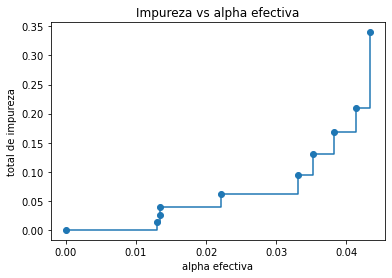

In [52]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("alpha efectiva")
ax.set_ylabel("total de impureza")
ax.set_title("Impureza vs alpha efectiva")

In [53]:
models = []
for ccp_alpha in ccp_alphas:
    mod = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    mod.fit(X_train, y_train)
    models.append(mod)
print("Numero de nodos en el ultimo arbol es: {} con ccp_alpha: {}".format(
      models[-1].tree_.node_count, ccp_alphas[-1]))

Numero de nodos en el ultimo arbol es: 1 con ccp_alpha: 0.1588416867846118


In [54]:
models = models[:-1]
ccp_alphas = ccp_alphas[:-1]

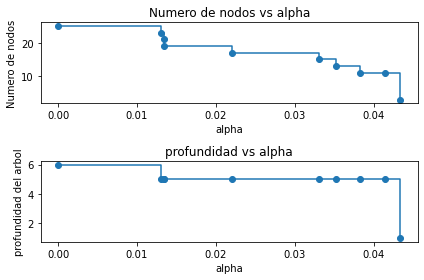

In [55]:
node_counts = [mod.tree_.node_count for mod in models]
depth = [mod.tree_.max_depth for mod in models]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("Numero de nodos")
ax[0].set_title("Numero de nodos vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("profundidad del arbol")
ax[1].set_title("profundidad vs alpha")
fig.tight_layout()

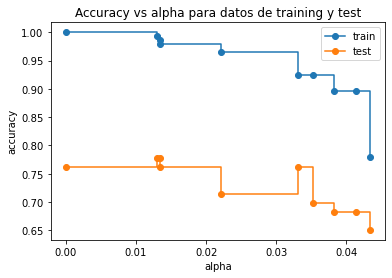

In [56]:
train_scores = [mod.score(X_train, y_train) for mod in models]
test_scores = [mod.score(X_test, y_test) for mod in models]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha para datos de training y test")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

Ajustando un modelo Random Forest

In [60]:
seed=7
randomForest = RandomForestClassifier(max_depth=7,n_estimators=100, random_state=0)
randomForest.fit(X_train, y_train)


RandomForestClassifier(max_depth=7, random_state=0)

In [65]:
y_forest=randomForest.predict(X_test)
print('número de datos bien clasificados con Random Forest')
accuracy_score(y_test,y_forest,normalize=False)

número de datos bien clasificados con Random Forest


54

Tuvimos más datos mejor clasificados con los árboles de clasificación que con Random Forest
Vamos a ver cuál sería un mejor ajuste para los hiperparámetros

In [70]:

param_grid = {
    'max_depth' : [4,5,7,9,11],
    'max_samples' : [0.05, 0.1, 0.2, 0.5],
    'n_estimators' :[i for i in range(10,200,1)],
    'criterion':["gini", "entropy"],
    'max_features':['auto', 'sqrt']
}
seed=7
clf_rfhiper = RandomizedSearchCV(estimator=RandomForestClassifier(),param_distributions=param_grid, scoring = 'accuracy')
clf_rfhiper.fit(X_train, y_train)
clf_rfhiper.best_params_

{'n_estimators': 190,
 'max_samples': 0.5,
 'max_features': 'sqrt',
 'max_depth': 9,
 'criterion': 'gini'}

Vamos a ver que tal funciona el modelo que arroja los mejores parámetros deacuerdo
al RandomizedSearchCV

In [71]:
y_clf_rfhiper=clf_rfhiper.predict(X_test)
print('Porcentaje de datos bien clasificados')
print(accuracy_score(y_test,y_clf_rfhiper))
print('número de datos bien clasificados')
accuracy_score(y_test,y_clf_rfhiper,normalize=False)

Porcentaje de datos bien clasificados
0.8253968253968254
número de datos bien clasificados


52

Con los párametros de profundidad=9 y el criterio de Gini, obtenemos mejores resultados que con el 
modelo de árboles de decisión que presentamos antes

Ajustando un modelo con Bagging

In [81]:
seed=7
cart=tree.DecisionTreeClassifier(max_depth=7)
n_trees=62
baggingModel=BaggingClassifier(base_estimator=cart,n_estimators=n_trees,random_state=seed)
baggingModel.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),
                  n_estimators=62, random_state=7)

In [73]:
y_bag=baggingModel.predict(X_test)
print('Porcentaje de datos bien clasificados')
print(accuracy_score(y_test,y_bag))
print('número de datos bien clasificados')
accuracy_score(y_test,y_bag,normalize=False)

Porcentaje de datos bien clasificados
0.8095238095238095
número de datos bien clasificados


51

Vamos a ver que cambios en el porcentaje de clasificación tenemos si modificamos los
hiperparámetros

In [85]:
param_grid = {
    'base_estimator__max_depth' : [4,5,7,9,11],
    #'max_samples' : [0.05, 0.1, 0.2, 0.5],
    'n_estimators' :[i for i in range(10,100,1)],
    'base_estimator__criterion':["gini", "entropy"],
    #'max_features':[0.5,1]
}
seed=7
clf = GridSearchCV(BaggingClassifier(tree.DecisionTreeClassifier()),param_grid, scoring = 'accuracy')
clf.fit(X_train, y_train)
clf.best_params_

{'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 7,
 'n_estimators': 44}

Veamos los resultados que obtenemos utilizando los parámetros utilizando GridSearchCV con el
clasificador de Bagging

In [86]:
y_bag=clf.predict(X_test)
print('Porcentaje de datos bien clasificados')
print(accuracy_score(y_test,y_bag))
print('número de datos bien clasificados')
accuracy_score(y_test,y_bag,normalize=False)

Porcentaje de datos bien clasificados
0.8253968253968254
número de datos bien clasificados


52

Utilizando Grid Search para optimizar los parámetros del modelo obtenemos que
usando el criterio de entropía y una profundidad máxima de 7 el porcentaje de observaciones mejor clasificadas crece, de 80 a 82 por ciento, es decir solo marginalmente.

Modelo de Boosting

In [87]:
seed=7
n_trees=100
#usamos de base el modelo de árboles de decisión
# utilizado con anterioridad (cart)
boostingModel = AdaBoostClassifier(base_estimator=cart, n_estimators=n_trees,random_state=seed)
boostingModel.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),
                   n_estimators=100, random_state=7)

In [88]:
y_boost=boostingModel.predict(X_test)
print('Porcentaje de datos bien clasificados')
print(accuracy_score(y_test,y_boost))
print('número de datos bien clasificados')
accuracy_score(y_test,y_boost,normalize=False)

Porcentaje de datos bien clasificados
0.6825396825396826
número de datos bien clasificados


43

Obtenemos un porcentaje de datos bien clasificados del 0.68 por ciento. Con una profundidad de 7 y 100 estimadores.

Ajustando hiper parámetros:

In [91]:
seed=7
param_grid = {
    'base_estimator__max_depth' : [4,5,7,8,9,10],
    'n_estimators' :[i for i in range(10,50,1)],
    'learning_rate':[0.1,0.5,1]
}

boostingModelHiper = GridSearchCV(AdaBoostClassifier(tree.DecisionTreeClassifier(ccp_alpha= 0.015)),param_grid, scoring = 'accuracy')
boostingModelHiper.fit(X_train, y_train)
boostingModelHiper.best_params_

{'base_estimator__max_depth': 9, 'learning_rate': 1, 'n_estimators': 48}

In [94]:
y_boosthip=boostingModelHiper.predict(X_test)
print('Porcentaje de datos bien clasificados')
print(accuracy_score(y_test,y_boosthip))
print('número de datos bien clasificados')
accuracy_score(y_test,y_boosthip,normalize=False)

Porcentaje de datos bien clasificados
0.8095238095238095
número de datos bien clasificados


51

Con una profundidad de 9, una tasa de aprendizaje de 1 y 48 estimadores, tenemos un porcentaje de datos bien clasificados
del 80 por ciento. Lo que es mejor comparado con nuestro modelo original.


Obtenemos la matriz de confusión

array([[0.87096774, 0.25      ],
       [0.12903226, 0.75      ]])

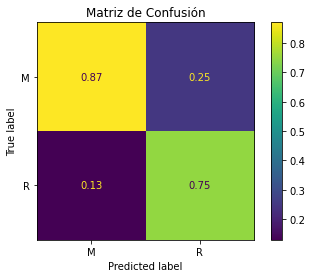

In [97]:
disp=metrics.plot_confusion_matrix(boostingModelHiper, X_test, y_test,normalize="pred")
disp.ax_.set_title("Matriz de Confusión")
disp.confusion_matrix

Vemos en la matriz de confusión que el modelo clasifica mejor a las observaciones que son minas (0.87 por ciento) y falla un poco más al clasificar Rocas (0.75 por ciento), pero en general clasifica adecuadamente.

In [108]:
#calculo de las probabilidades y el AUC
probs = boostingModelHiper.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds, pos_label='R')
roc_auc = metrics.auc(fpr, tpr)

Obtenemos la curva ROC

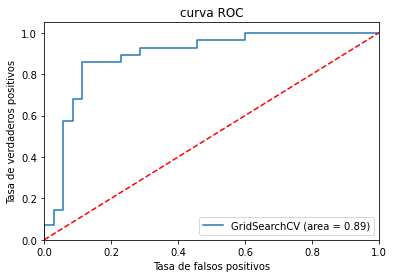

In [109]:
plt.figure()
plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('curva ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()